In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
file_path = 'E:/Final Dissertation/Final_Dataset/Final_Hourly_Dataset.csv'
data = pd.read_csv(file_path)

In [3]:
data = data[["Date","Time", "NO2_ppm_aeroequal", "NO2_µg/m³_council"]]
data['Datetime'] = pd.to_datetime(data['Date'] + ' ' + data['Time'])
data.set_index('Datetime', inplace=True)
data.drop(columns=['Date', 'Time'], inplace=True)

#### Convert ppm to Micrograms per cubic meter (µg/m3)

In [4]:
# data['NO2_ppm_aeroequal'] = data['NO2_ppm_aeroequal'].apply(lambda x: 0 if x < 0 else x)
# data['NO2_µg/m³_council'] = data['NO2_µg/m³_council'].apply(lambda x: 0 if x < 0 else x)

data['NO2_ppm_aeroequal'] = data['NO2_ppm_aeroequal'] * 1912.5  #(Department for Environment Food & Rural Affairs, n.d.)

In [5]:
data.head()

,NO2_ppm_aeroequal,NO2_µg/m³_council
Datetime,,
2024-08-15 15:00:00,0.000000,10.53788
2024-08-15 16:00:00,0.000000,14.91272
2024-08-15 17:00:00,3.474375,15.33347
2024-08-15 18:00:00,8.765625,10.63350
2024-08-15 19:00:00,7.012500,11.32200


In [6]:
print("Basic Information:")
print(data.info())

Basic Information:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 55 entries, 2024-08-15 15:00:00 to 2024-08-22 19:00:00
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   NO2_ppm_aeroequal  55 non-null     float64
 1   NO2_µg/m³_council  55 non-null     float64
dtypes: float64(2)
memory usage: 1.3 KB
None


#### No null or non numeric values

In [7]:
print("\nSummary Statistics:")
data.describe()


Summary Statistics:


,NO2_ppm_aeroequal,NO2_µg/m³_council
count,55.000000,55.000000
mean,3.728539,14.023581
std,6.053741,4.581423
min,0.000000,7.975130
25%,0.000000,10.870170
50%,0.414375,12.761160
75%,6.910500,15.347815
max,32.416875,28.128090


#### Select only positive values, as NO2 can never be negative. (Reliable Gas Safety Systems, n.d.)

In [8]:
data = data[data['NO2_µg/m³_council'] >= 0]
data = data[data['NO2_ppm_aeroequal'] >= 0]

In [9]:
print("\nChecking for missing values:")
print(data.isnull().sum())


Checking for missing values:
NO2_ppm_aeroequal    0
NO2_µg/m³_council    0
dtype: int64


## Plot the trend

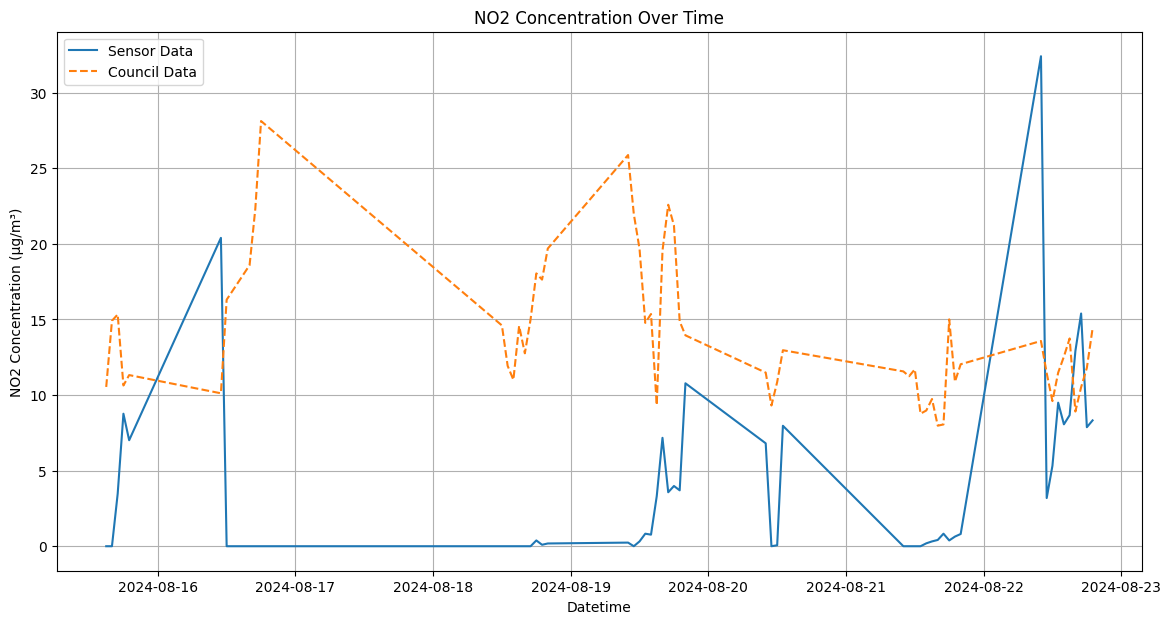

In [10]:
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['NO2_ppm_aeroequal'], label='Sensor Data')
plt.plot(data.index, data['NO2_µg/m³_council'], label='Council Data', linestyle='--')
plt.xlabel('Datetime')
plt.ylabel('NO2 Concentration (µg/m³)')
plt.title('NO2 Concentration Over Time')
plt.legend()
plt.grid(True)
plt.show()

#### While the collected data manages to follow the pattern in some parts, model development requires a much better dataset

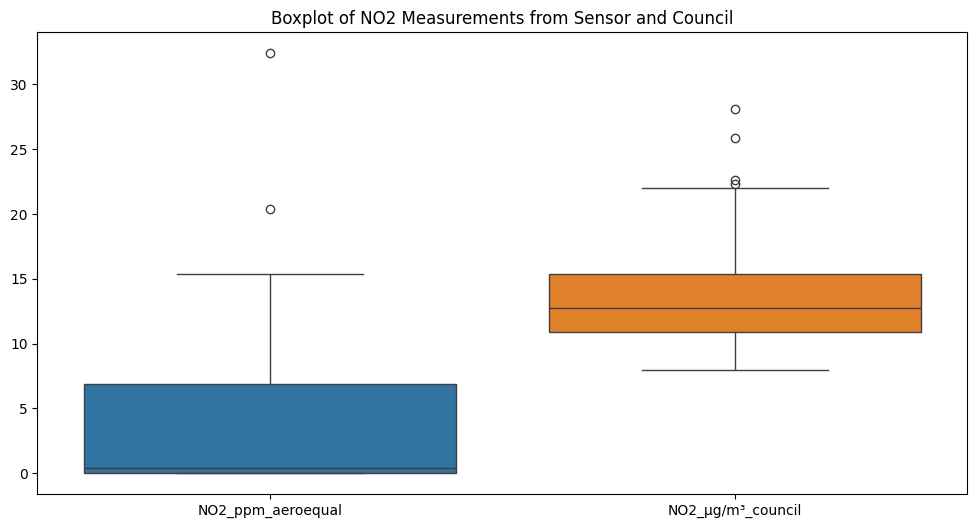

In [11]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=data[['NO2_ppm_aeroequal', 'NO2_µg/m³_council']])
plt.title('Boxplot of NO2 Measurements from Sensor and Council')
plt.show()


Correlation Matrix:


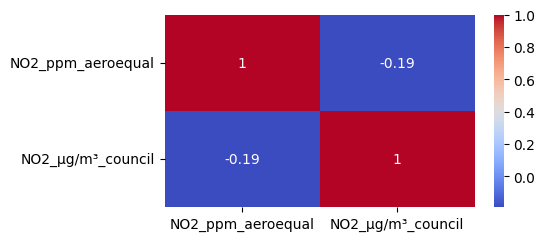

In [12]:
print("\nCorrelation Matrix:")
plt.figure(figsize=(5, 2.5))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.show()


Distribution of Target Variable NO2_ppm_aeroequal :


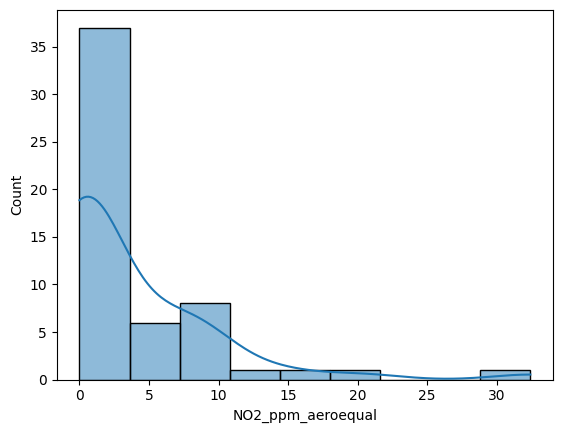

In [13]:
print("\nDistribution of Target Variable NO2_ppm_aeroequal :")
sns.histplot(data['NO2_ppm_aeroequal'], kde=True)
plt.show()


Distribution of Target Variable NO2_µg/m³_council:


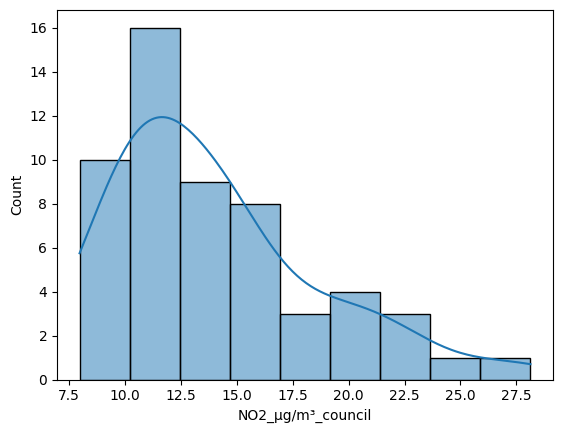

In [14]:
print("\nDistribution of Target Variable NO2_µg/m³_council:")
sns.histplot(data['NO2_µg/m³_council'], kde=True)
plt.show()


Scatter plot between features and target variable:


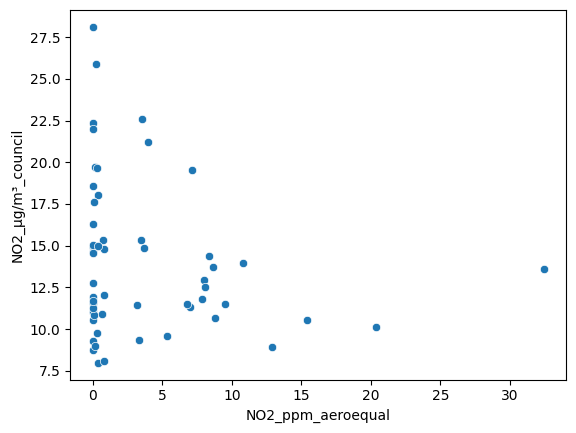

In [15]:
print("\nScatter plot between features and target variable:")
sns.scatterplot(x=data['NO2_ppm_aeroequal'], y=data['NO2_µg/m³_council'])
plt.show()

## Outlier Detection

In [16]:
data['Difference'] = abs(data['NO2_ppm_aeroequal'] - data['NO2_µg/m³_council'])
significant_discrepancies = data[data['Difference'] > data['Difference'].mean() + 2 * data['Difference'].std()]
significant_discrepancies

,NO2_ppm_aeroequal,NO2_µg/m³_council,Difference
Datetime,,,
2024-08-16 18:00:00,0.000000,28.12809,28.128090
2024-08-19 10:00:00,0.239063,25.88091,25.641848


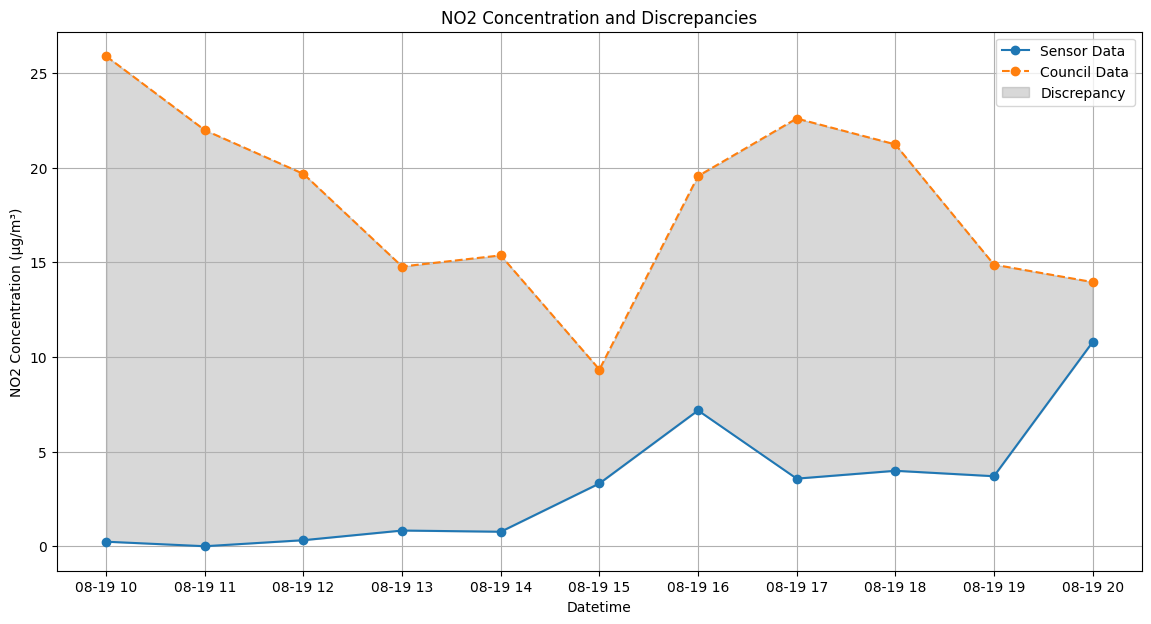

In [17]:
unique_dates = significant_discrepancies.index.date
unique_dates = np.unique(unique_dates)
for date in unique_dates:
    outlier_data = data.loc[data.index.date == date]

plt.figure(figsize=(14, 7))
plt.plot(outlier_data.index, outlier_data['NO2_ppm_aeroequal'], label='Sensor Data', marker = 'o')
plt.plot(outlier_data.index, outlier_data['NO2_µg/m³_council'], label='Council Data', linestyle='--', marker = 'o')
plt.fill_between(outlier_data.index, outlier_data['NO2_ppm_aeroequal'], outlier_data['NO2_µg/m³_council'], color='grey', alpha=0.3, label='Discrepancy')
plt.xlabel('Datetime')
plt.ylabel('NO2 Concentration (µg/m³)')
plt.title('NO2 Concentration and Discrepancies')
plt.legend()
plt.grid(True)
plt.show()

#### Manually tested IQR from 0.5 to 1.5 and Z-score from 0.5 to 3, retaining most data points and a few outliers.

## Outlier Removal using IQR

In [18]:
Q1 = data['Difference'].quantile(0.25)
Q3 = data['Difference'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 0.7 * IQR
upper_bound = Q3 + 0.7 * IQR

iqr_outliers = data[(data['Difference'] < lower_bound) | (data['Difference'] > upper_bound)]
data = data[(data['Difference'] >= lower_bound) & (data['Difference'] <= upper_bound)]
print("IQR Outliers Removed:")
iqr_outliers

IQR Outliers Removed:


,NO2_ppm_aeroequal,NO2_µg/m³_council,Difference
Datetime,,,
2024-08-16 17:00:00,0.000000,22.33322,22.333220
2024-08-16 18:00:00,0.000000,28.12809,28.128090
2024-08-19 10:00:00,0.239063,25.88091,25.641848
2024-08-19 11:00:00,0.000000,21.97463,21.974630


## Outlier Removal using Z Score

In [19]:
data['Z_Score'] = (data['Difference'] - data['Difference'].mean()) / data['Difference'].std()
z_score_outliers = data[data['Z_Score'].abs() > 2.5]
data = data[data['Z_Score'].abs() <= 2.5]
print("Z-Score Outliers Removed:")
z_score_outliers

Z-Score Outliers Removed:


,NO2_ppm_aeroequal,NO2_µg/m³_council,Difference,Z_Score
Datetime,,,,


In [20]:
data['Difference'] = abs(data['NO2_ppm_aeroequal'] - data['NO2_µg/m³_council'])
significant_discrepancies = data[data['Difference'] > data['Difference'].mean() + 2 * data['Difference'].std()]
significant_discrepancies

,NO2_ppm_aeroequal,NO2_µg/m³_council,Difference,Z_Score
Datetime,,,,


In [21]:
data.drop(columns=['Difference', 'Z_Score'], inplace=True)

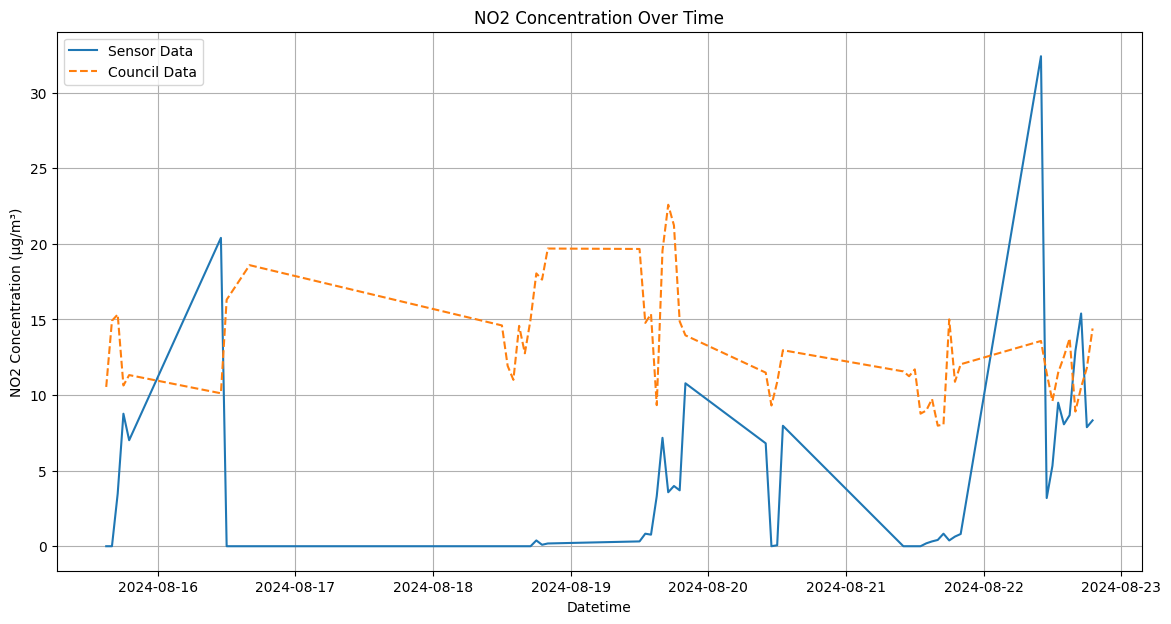

In [22]:
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['NO2_ppm_aeroequal'], label='Sensor Data')
plt.plot(data.index, data['NO2_µg/m³_council'], label='Council Data', linestyle='--')
plt.xlabel('Datetime')
plt.ylabel('NO2 Concentration (µg/m³)')
plt.title('NO2 Concentration Over Time')
plt.legend()
plt.grid(True)
plt.show()

## Check the Final distribution and Outliers

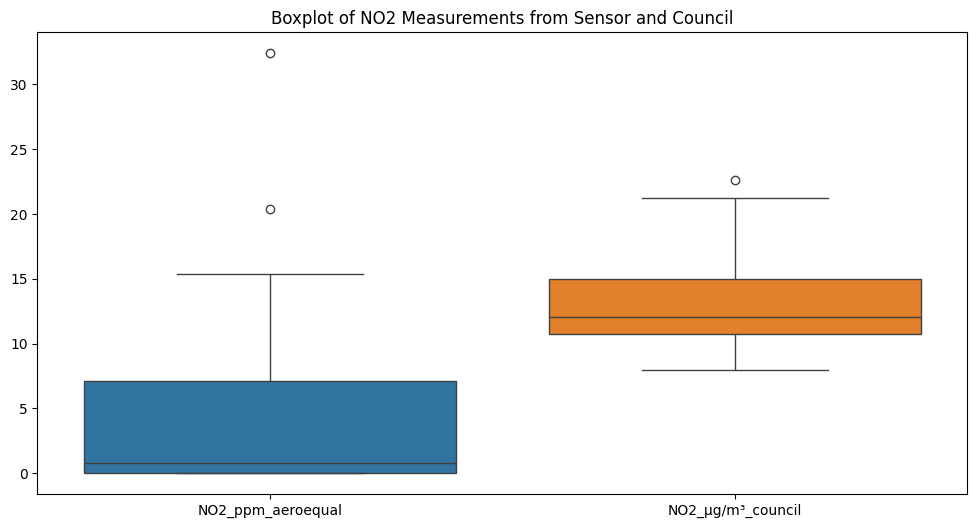

In [23]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=data[['NO2_ppm_aeroequal', 'NO2_µg/m³_council']])
plt.title('Boxplot of NO2 Measurements from Sensor and Council')
plt.show()


Correlation Matrix:


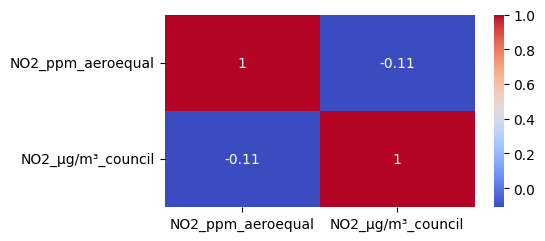

In [24]:
print("\nCorrelation Matrix:")
plt.figure(figsize=(5, 2.5))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.show()


Scatter plot between features and target variable:


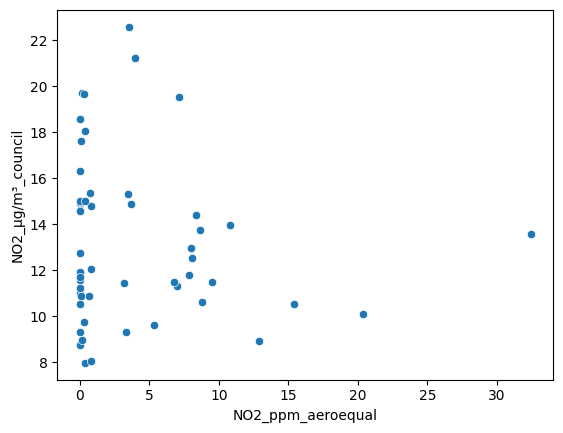

In [25]:
print("\nScatter plot between features and target variable:")
sns.scatterplot(x=data['NO2_ppm_aeroequal'], y=data['NO2_µg/m³_council'])
plt.show()

In [26]:
print("Basic Information:")
print(data.info())

Basic Information:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 51 entries, 2024-08-15 15:00:00 to 2024-08-22 19:00:00
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   NO2_ppm_aeroequal  51 non-null     float64
 1   NO2_µg/m³_council  51 non-null     float64
dtypes: float64(2)
memory usage: 1.2 KB
None


In [27]:
data.to_csv('E:/Final Dissertation/Cleaned_Dataset/NO2_aeroequal_and_council.csv')

#### References
######
###### Department for Environment Food & Rural Affairs, U.A., n.d.
###### Report: Conversion Factors Between ppb and µg m-3 and ppm and mgm-3 - Defra, UK.
###### [online] Available at: <https://uk-air.defra.gov.uk/library/reports?report_id=306>.
######
###### Reliable Gas Safety Systems, G.D., n.d. 
###### Why do I see negative readings on my gas monitor? 
###### [online] Available at: <https://www.gasdetectors.co.nz/why-do-i-see-negative-readings-on-my-gas-monitor/>.